# Inverse Kinematics tutorial

we'll demonstrate inverse kinematics on a baxter robot

## Setup

In [1]:
import numpy as np

from pykin.robot import Robot
from pykin.kinematics.transform import Transform
from pykin.utils import plot_utils as plt
from pykin.utils.kin_utils import ShellColors as sc

In [2]:
# set baxter urdf files path
file_path = '../asset/urdf/baxter/baxter.urdf'

# set your robot
robot = Robot(fname=file_path, offset=Transform(rot=[0.0, 0.0, 0.0], pos=[0, 0, 0]))

In [3]:
# set the angles you want
head_thetas = np.array([0.0])
right_arm_thetas = np.array([np.pi/4, 0, 0, np.pi/3, 0, 0, 0])
left_arm_thetas = np.array([-np.pi/4, 0, np.pi/6, 0, 0, np.pi/2, 0])

### Compute the forward kinematics to set the robot's pose you want.

In [4]:
thetas = np.concatenate((head_thetas ,right_arm_thetas ,left_arm_thetas))
transformations = robot.kin.forward_kinematics(thetas=thetas)

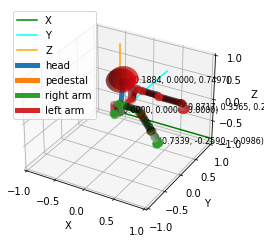

In [5]:
fig, ax = plt.init_3d_figure()
plt.plot_robot(robot, 
               transformations=transformations,
               ax=ax, 
               name=robot.robot_name,
               visible_visual=False, 
               visible_collision=True, 
               mesh_path='../asset/urdf/baxter/')
ax.legend()

## Compute Inverse Kinematics

### For compute IK solution, you must set robot's pose
First, you must set joint initial angles using np.random.randn

In [6]:
init_right_thetas = np.random.randn(7)
init_left_thetas = np.random.randn(7)

Set from base frame to end effector frame


In [7]:
robot.set_desired_frame("base", "right_wrist")

### Use FK to find the end effector pose you want

In [8]:
target_r_pose = np.concatenate((transformations["right_wrist"].pos, transformations["right_wrist"].rot))

Target pose's shape for Inverse Kinematics is (7,)

Combine position(x,y,z) and orientation(quaternion: w,x,y,z)

In [9]:
target_r_pose

array([ 7.33919486e-01, -2.59028615e-01, -9.86059446e-02,  2.58819045e-01,
        8.87010919e-07,  9.65925826e-01, -2.37663132e-07])

### Get the target joints using inverse kinematics.

Iterators is the number of iterations to update the joint angle 

WorkingTime is how long this function takes to execute.

In [10]:
# The return value of inverse kinematics is the final joint angle and a list of joints obtained during the process of finding the solution.
# There are two method options, LM and NR and maxIter indicates the maximum number of iterations to find a solution.
# NR means to Newton Raphson and LM means to levenberg-marquardt.
ik_right_LM_result, trajectory = robot.kin.inverse_kinematics(init_right_thetas, target_r_pose, method="LM", maxIter=100)
print(ik_right_LM_result, trajectory)

Iterators : 6
WorkingTime[inverse_kinematics]: 0.0252 sec

[ 0.76765537  0.89084004 -0.06173746 -0.7262956   0.02391873  0.88202734
  0.03042339] [array([ 0.98958331,  0.66574816,  0.06645985, -0.17754493, -0.26953615,
        0.91227587,  0.90403054]), array([ 0.89175712,  0.66198647, -0.08545283, -0.27682336, -0.37251043,
        0.83252342,  0.63273133]), array([ 0.82091135,  0.77613436, -0.07250337, -0.49003779, -0.23541012,
        0.7611267 ,  0.32251359]), array([ 0.78206911,  0.8796672 , -0.06132192, -0.69908556, -0.02742225,
        0.84038747,  0.0785428 ]), array([ 0.76830876,  0.89087944, -0.0617925 , -0.72608067,  0.02304232,
        0.88022187,  0.03134948]), array([ 0.76766584,  0.89083811, -0.06173497, -0.72627978,  0.02387833,
        0.88199165,  0.0304656 ]), array([ 0.76765537,  0.89084004, -0.06173746, -0.7262956 ,  0.02391873,
        0.88202734,  0.03042339])]


### Similarly, the process is the same for the left arm.

In [11]:
robot.set_desired_frame("base", "left_wrist")
target_l_pose = np.concatenate((transformations["left_wrist"].pos, transformations["left_wrist"].rot))
ik_left_LM_result, _ = robot.kin.inverse_kinematics(init_left_thetas, target_l_pose, method="LM", maxIter=100)
print(ik_left_LM_result)

Iterators : 27
WorkingTime[inverse_kinematics]: 0.0847 sec

[-0.84109887  0.09434589  1.69385071  0.02946483 -1.17192953  1.50543064
 -0.06819402]


### With the joints obtained above, we will find the kinematics of the baxter robot and see the results.

In [12]:
thetas = np.concatenate((head_thetas, ik_right_LM_result, ik_left_LM_result))
robot.reset_desired_frames()
result_fk = robot.kin.forward_kinematics(thetas)

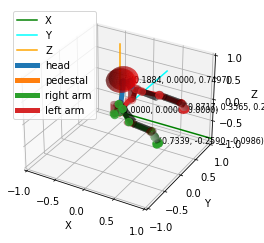

In [13]:
_, ax = plt.init_3d_figure("LM IK Result")
plt.plot_robot(robot, 
               result_fk, 
               ax,
               robot.robot_name,
               visible_visual=False, 
               visible_collision=True)
ax.legend()

### Check whether the error result of the pose you have set and the pose you have drawn out by solving IK is good.

In [14]:
right_arm_pose_err = robot.compute_pose_error(
    target=transformations["right_wrist"].h_mat,
    result=result_fk["right_wrist"].h_mat)

left_arm_pose_err = robot.compute_pose_error(
    target=transformations["left_wrist"].h_mat,
    result=result_fk["left_wrist"].h_mat)

print(right_arm_pose_err, left_arm_pose_err)

2.436323783359676e-06 1.5058878811802243e-06
